#import dependencies

In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime as dt
from datetime import timedelta

In [5]:
import numpy as np
import pandas as pd

# Reflect Tables into SQLAlchemy ORM

#Python SQL toolkit and Object Relational Mapper


In [6]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

#reflect an existing database into a new model


In [8]:
base = automap_base()



#reflect the tables


In [9]:
base.prepare(engine, reflect = True)

C:\Users\hashe\anaconda3\lib\site-packages\sqlalchemy\ext\declarative\clsregistry.py:129: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.measurement, and will be replaced in the string-lookup table.
  % (item.__module__, item.__name__)
C:\Users\hashe\anaconda3\lib\site-packages\sqlalchemy\ext\declarative\clsregistry.py:129: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.station, and will be replaced in the string-lookup table.
  % (item.__module__, item.__name__)


In [109]:
# We can view all of the classes that automap found
from sqlalchemy import create_engine, inspect, func
inspector = inspect(engine)
inspector.get_table_names()



['measurement', 'station']

#Save references to each table


In [110]:
Station = base.classes.station
Measurement = base.classes.measurement

#find the name and type of  Station


In [111]:
for comp in inspector.get_columns('Station'):
     print(comp["name"], comp["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [112]:
for comp in inspector.get_columns('Measurement'):
     print(comp["name"], comp["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#Create our session (link) from Python to the DB

In [113]:
session = Session(engine)


# Exploratory Climate Analysis

# Design a query to retrieve the last 12 months of precipitation data and plot the results


#find the last date of precipitation


In [114]:
for comp in session.query(Measurement.date).order_by(Measurement.date.desc()).first():
    last_date=comp

last_date

'2017-08-23'

#Calculate the date 1 year ago from the last data point in the database


In [115]:
twelve_months_ago= dt.strptime(last_date, '%Y-%m-%d') - timedelta(days=365)
twelve_months_ago = dt.strftime(twelve_months_ago, '%Y-%m-%d')
twelve_months_ago


'2016-08-23'

#Perform a query to retrieve the data and precipitation scores


In [116]:
results = session.query (Measurement.date, Measurement.prcp).filter(Measurement.date>=twelve_months_ago).all()
results
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results,columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df.set_index("Date", inplace=True)
df=df.sort_index()
df



,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [14]:
import matplotlib


#Use Pandas Plotting with Matplotlib to plot the data


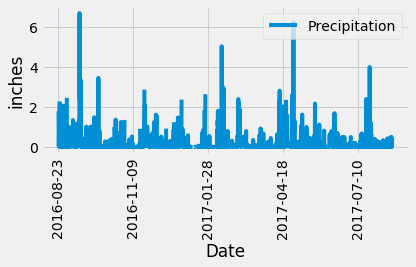

In [117]:
plot=df.plot(rot=90)
plot.set_xlabel("Date")
plot.set_ylabel("inches")
plt.legend(loc='upper right')
plt.tight_layout()

# save imapge 
plt.savefig("Images/precepitation.png")

plt.show()


In [118]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?


In [119]:
station = session.query(Measurement.station).group_by(Measurement.station).count()
print(f'{station} station are avaiable')

9 station are avaiable


In [120]:
# What are the most active stations? (i.e. what stations have the most rows)?
sel1 = [Measurement.station,
       func.count(Measurement.station)]
most_active_station = session.query(*sel1).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).first()

most_active_station

('USC00519281', 2772)

In [121]:
# List the stations and the counts in descending order.
station_list = session.query(*sel1).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
station_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

#convert the previos resuly to a dataframe


In [122]:
df_station =pd.DataFrame(station_list, columns=["Station ID", "Station count"])
df_station


,Station ID,Station count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


#Using the station id from the previous query, calculate the lowest temperature recorded, 
#highest temperature recorded, and average temperature of the most active station?

In [123]:


sel3 = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs),
       func.count(Measurement.tobs),]
MostActStationTemp = session.query(*sel3).\
    filter(Measurement.station == 'USC00519281').\
    group_by(Measurement.station).\
    order_by(func.max(Measurement.tobs).desc()).all()
for x in  MostActStationTemp:  
    print(f'The most active station is {x[0]}')
    print(f'The minimum recorded temperature in this station is {x[1]}')
    print(f'The maximum recorded temperature in this station is {x[2]}')
    print(f'The average recorded temperature in this station is {x[3]}')
    print(f'The number of recorded temperature in this station is {x[4]}')


The most active station is USC00519281
The minimum recorded temperature in this station is 54.0
The maximum recorded temperature in this station is 85.0
The average recorded temperature in this station is 71.66378066378067
The number of recorded temperature in this station is 2772


In [124]:
# Choose the station with the highest number of temperature observations.
sel4 = [Measurement.station,
       func.count(Measurement.tobs)]
MaxTempNumRead = session.query(*sel4).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).first()
print(MaxTempNumRead)

('USC00519281', 2772)


In [134]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel5 = [Measurement.station,
        Measurement.tobs,
       func.count(Measurement.tobs)]

Last12Temp = session.query(*sel5).\
    filter(Measurement.date > '2016-08-23').\
    filter(Measurement.station == 'USC00519281').\
    group_by(Measurement.tobs).\
    order_by(Measurement.tobs).all()

Last12Temp


[('USC00519281', 59.0, 3),
 ('USC00519281', 60.0, 2),
 ('USC00519281', 61.0, 1),
 ('USC00519281', 62.0, 6),
 ('USC00519281', 63.0, 4),
 ('USC00519281', 64.0, 3),
 ('USC00519281', 65.0, 7),
 ('USC00519281', 66.0, 5),
 ('USC00519281', 67.0, 15),
 ('USC00519281', 68.0, 12),
 ('USC00519281', 69.0, 19),
 ('USC00519281', 70.0, 22),
 ('USC00519281', 71.0, 18),
 ('USC00519281', 72.0, 22),
 ('USC00519281', 73.0, 18),
 ('USC00519281', 74.0, 39),
 ('USC00519281', 75.0, 33),
 ('USC00519281', 76.0, 33),
 ('USC00519281', 77.0, 30),
 ('USC00519281', 78.0, 22),
 ('USC00519281', 79.0, 18),
 ('USC00519281', 80.0, 11),
 ('USC00519281', 81.0, 4),
 ('USC00519281', 82.0, 3),
 ('USC00519281', 83.0, 1)]

In [150]:
#define axis to make a histogram
x_axis=[]
y_axis=[]
for x, y,z in Last12Temp:    
    x_axis.append(y)
    y_axis.append(z)
print(x_axis)

#creat a histogram


 

[59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0]


(array([3., 2., 3., 2., 2., 3., 2., 3., 2., 3.]),
 array([59. , 61.4, 63.8, 66.2, 68.6, 71. , 73.4, 75.8, 78.2, 80.6, 83. ]),
 <a list of 10 Patch objects>)

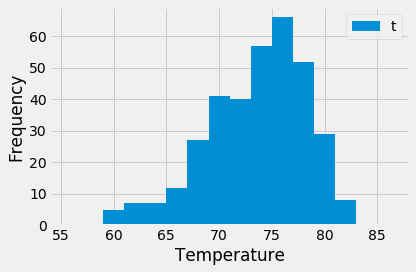

In [168]:

plt.xlim([min(x_axis)-5, max(x_axis)+5])
plt.hist(x_axis, weights=y_axis, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend('tobs')

plt.tight_layout()

# save imapge 
plt.savefig("Images/station-histogram.png")

plt.show()


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
